In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import to_categorical

import pandas as pd
# import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

In [2]:
# Load the dataset with the correct delimiter (semicolon)
dropout_data = pd.read_csv("dropout.csv", delimiter=';')

# Convert the 'Target' column into numeric values
label_encoder = LabelEncoder()
print(pd.get_dummies(dropout_data['Target']))
dropout_data['Target'] = label_encoder.fit_transform(dropout_data['Target'])

# Split the data into features and the target
X = dropout_data.drop(columns=['Target'])
X = X.drop(columns=['Nacionality', 
                    'Mother\'s qualification', 
                    'Father\'s qualification', 
                    'Mother\'s occupation',
                    'Father\'s occupation',
                    'Educational special needs', 
                    'International', 
                    'Curricular units 1st sem (without evaluations)',
                    'Curricular units 2nd sem (without evaluations)',
                    'Unemployment rate', 
                    # 'Application mode',
                    'Inflation rate'], axis=1)
print(f"Feature: {(X.columns)}")
# X = X[outputs[0]]
y = dropout_data['Target']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

      Dropout  Enrolled  Graduate
0        True     False     False
1       False     False      True
2        True     False     False
3       False     False      True
4       False     False      True
...       ...       ...       ...
4419    False     False      True
4420     True     False     False
4421     True     False     False
4422    False     False      True
4423    False     False      True

[4424 rows x 3 columns]
Feature: Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Admission grade', 'Displaced',
       'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricula

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import numpy as np

print("Original Dataset:", Counter(y_train))
under = RandomUnderSampler(sampling_strategy='auto')
pipeline = Pipeline([('u', under)])
X_train, y_train = pipeline.fit_resample(X_train, y_train)

print("Balanced Dataset:", Counter(y_train))

Original Dataset: Counter({2: 1759, 0: 1137, 1: 643})
Balanced Dataset: Counter({0: 643, 1: 643, 2: 643})


In [4]:
rfc = RandomForestClassifier(random_state=0)
modelList = [RandomForestClassifier]
for model in modelList:
    arr = []
    for i in range(0,50,2):
        m = model(random_state=i)
        m.fit(X_train,y_train)
        y_pred = m.predict(X_test)
        arr.append((i,accuracy_score(y_test,y_pred)))
    print(max(arr,key= lambda x:x[1]))

(48, 0.7570621468926554)
(0, 0.7367231638418079)


In [6]:
import warnings
warnings.filterwarnings("ignore")
arr = []
for n_estimators in [150,175]:
    for max_depth in [5,6,7,8]:
        for learning_rate in [0.4,0.5,0.6]:
            m = XGBClassifier(learning_rate = learning_rate,n_estimators=n_estimators,max_depth=max_depth, tree_method = "hist", device = "cuda")
            m.fit(X_train,y_train)
            y_pred = m.predict(X_test)
            # print(accuracy_score(y_test,y_pred))
            arr.append(((n_estimators,max_depth,learning_rate),accuracy_score(y_test,y_pred)))
print(max(arr,key= lambda x:x[1]))

((175, 8, 0.4), 0.7536723163841808)


In [7]:
rfc = RandomForestClassifier(random_state=48)
xbc = XGBClassifier(learning_rate = 0.4,n_estimators=175,max_depth=8, tree_method = "hist", device = "cuda")

In [8]:
rfc.fit(X_train,y_train)
xbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=175, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [9]:
y_pred = rfc.predict(X_test)
print("RandomForest Accuracy\t\t :",round(accuracy_score(y_test,y_pred)*100,5),"%")
print(classification_report(y_test,y_pred,target_names=['Dropout','Enrolled','Graduate']))

y_pred = xbc.predict(X_test)
print("XGBoost Accuracy\t\t :",round(accuracy_score(y_test,y_pred)*100,5),"%")
print(classification_report(y_test,y_pred,target_names=['Dropout','Enrolled','Graduate']))

RandomForest Accuracy		 : 75.70621 %
              precision    recall  f1-score   support

     Dropout       0.86      0.70      0.77       284
    Enrolled       0.44      0.74      0.55       151
    Graduate       0.90      0.80      0.84       450

    accuracy                           0.76       885
   macro avg       0.73      0.75      0.72       885
weighted avg       0.81      0.76      0.77       885

XGBoost Accuracy		 : 75.36723 %
              precision    recall  f1-score   support

     Dropout       0.85      0.74      0.79       284
    Enrolled       0.44      0.66      0.53       151
    Graduate       0.87      0.80      0.83       450

    accuracy                           0.75       885
   macro avg       0.72      0.73      0.72       885
weighted avg       0.79      0.75      0.77       885



In [18]:
ens1 = VotingClassifier(estimators=[('rfc', rfc), ('xbc',xbc),("abc",abc),("lr",lr)], voting='hard')
ens1.fit(X_train, y_train)

y_pred = ens1.predict(X_test)
print("Voting Classifier Accuracy :",round(accuracy_score(y_test,y_pred)*100,2),"%")
print(classification_report(y_test,y_pred))

Voting Classifier Accuracy : 75.03 %
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       284
           1       0.43      0.70      0.53       151
           2       0.89      0.78      0.83       450

    accuracy                           0.75       885
   macro avg       0.72      0.74      0.72       885
weighted avg       0.80      0.75      0.77       885



In [10]:
ens2 = VotingClassifier(estimators=[('rfc', rfc), ('xbc',xbc)], voting='soft')
ens2.fit(X_train, y_train)

y_pred = ens2.predict(X_test)
print("Voting Classifier Accuracy :",round(accuracy_score(y_test,y_pred)*100,2),"%")
print(classification_report(y_test,y_pred))

Voting Classifier Accuracy : 75.25 %
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       284
           1       0.44      0.69      0.53       151
           2       0.88      0.79      0.84       450

    accuracy                           0.75       885
   macro avg       0.72      0.73      0.72       885
weighted avg       0.80      0.75      0.77       885



XGBoost
[[0.73591549 0.16901408 0.09507042]
 [0.17218543 0.66225166 0.16556291]
 [0.02666667 0.17777778 0.79555556]]
Random Forest
[[0.70422535 0.21478873 0.08098592]
 [0.14569536 0.73509934 0.1192053 ]
 [0.02444444 0.17777778 0.79777778]]
VotingClassifier
[[0.72183099 0.18661972 0.0915493 ]
 [0.16556291 0.68874172 0.14569536]
 [0.02444444 0.18222222 0.79333333]]


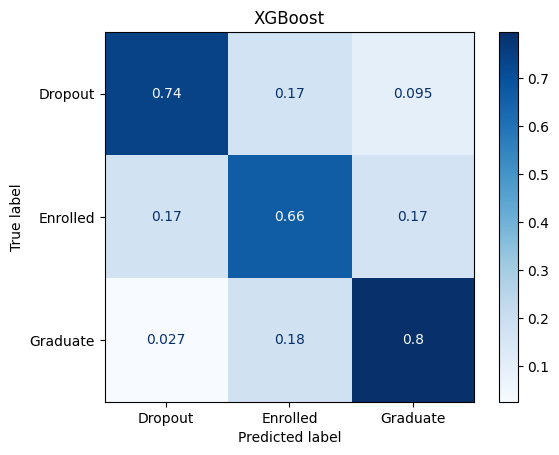

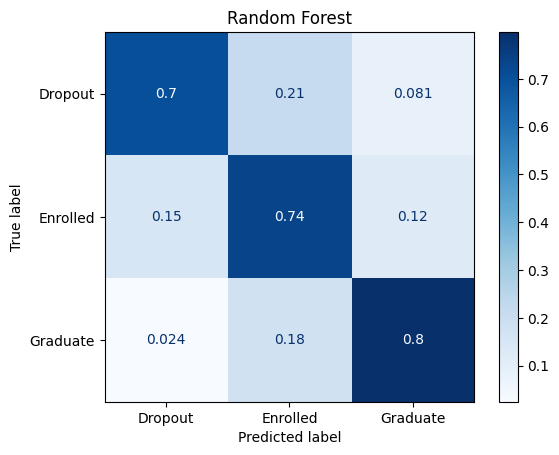

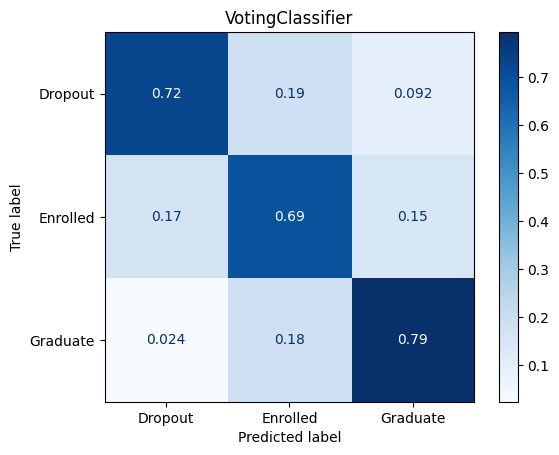

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
titles = [("XGBoost",xbc),("Random Forest",rfc),("VotingClassifier",ens2)]
for title, classifier in titles:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=["Dropout",  "Enrolled",  "Graduate"],
        cmap=plt.cm.Blues,
        normalize='true',
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [13]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import numpy as np

kf = KFold(n_splits=10)
kf.get_n_splits(X)
MSE = []
Acc = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    under = RandomUnderSampler(sampling_strategy='auto',random_state=21)
    pipeline = Pipeline(steps=[('u', under)])
    X_train, y_train = pipeline.fit_resample(X_train, y_train)

    vc = VotingClassifier(estimators=[('rfc', rfc), ('xbc',xbc)], voting='soft')
    vc.fit(X_train, y_train)
    

    y_pred = vc.predict(X_test)
    print("Voting Classifier Accuracy :",round(accuracy_score(y_test,y_pred)*100,2),"%")
    Acc.append(round(accuracy_score(y_test,y_pred)*100,2))
print(Acc)
print(sum(Acc)/len(Acc))


Fold 0:
Voting Classifier Accuracy : 72.23 %
Fold 1:
Voting Classifier Accuracy : 71.78 %
Fold 2:
Voting Classifier Accuracy : 75.62 %
Fold 3:
Voting Classifier Accuracy : 74.04 %
Fold 4:
Voting Classifier Accuracy : 76.02 %
Fold 5:
Voting Classifier Accuracy : 71.27 %
Fold 6:
Voting Classifier Accuracy : 74.66 %
Fold 7:
Voting Classifier Accuracy : 74.43 %
Fold 8:
Voting Classifier Accuracy : 69.0 %
Fold 9:
Voting Classifier Accuracy : 72.17 %
[72.23, 71.78, 75.62, 74.04, 76.02, 71.27, 74.66, 74.43, 69.0, 72.17]
73.12199999999999
